# 인물 사진 모드 구현 및 분석

# step1) 이미지 준비

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

dir_path = os.getenv('HOME')+'/aiffel/enode8/human_segmentation/images/'

In [12]:
img_path = os.getenv('HOME')+'/aiffel/enode8/human_segmentation/images/human.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1397, 1125, 3)


# step2) 시맨틱 세그멘테이션 모델 불러오기

## 2-1. 구글에서 제공하는 DeepLabModel 클래스 사용

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    # OpenCV 의 BGR을 TensorFlow의 RGB로 변경
    def preprocess(self, img_orig): # 전처리
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image): # 실제 세그멘테이션 진행 함수
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## 2-2. 사전 학습된 가중치로 모델 초기화

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/enode8/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/enode8/human_segmentation/models
model loaded successfully!


# step3) 피사체-배경 분리

## 3-1. 네트워크에 이미지 입력

In [13]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) # shpae는 Height, Width, Channel

(1397, 1125, 3) (513, 413, 3) 15


## 3-2. `PASCALVOC` 라벨

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## 3-3. 사람 영역 마스크 생성 및 시각화

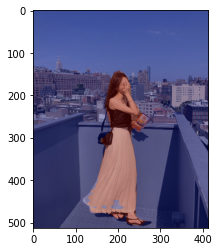

In [14]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 3-4. 세그멘테이션 결과 마스크 원래 크기로 복원

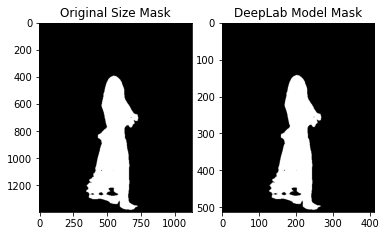

In [15]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) ## 확실한 경계 정하기

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# step4) 배경 흐리게 만들기

## 4-1. 전체 이미지 흐리게 만들기

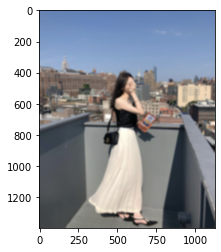

In [16]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 4-2. 세그멘테이션 마스크로 배경만 추출

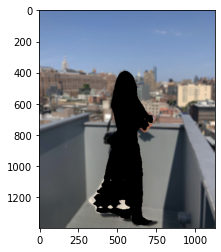

In [17]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# step5) 흐린 배경과 원본 이미지 인물 합성

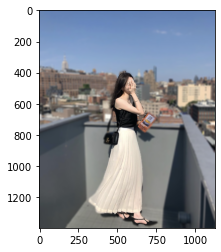

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# step6) 인물 모드 및 크로마키 합성 모듈화

In [7]:
def save(img, name):
    cv2.imwrite(os.getenv('HOME')+'/aiffel/enode8/human_segmentation/images/'+name+'.jpg', img)

## 6-1. 인물모드 함수
- def `make_portrait(img_name, mode)`
    - 이미지 파일명과 `PASCALVOC`의 라벨 중 어떤 객체를 식별할 것인지를 인자로 받아 아웃포커싱처리 된 cv2 이미지 객체 반환

In [21]:
def make_portrait(img_name, mode):
    '''
        mode = 15면 사람
        mode = 8이면 고양이
    '''
    img_path = os.getenv('HOME')+'/aiffel/enode8/human_segmentation/images/'+img_name
    # 이미지 불러오기
    img_orig = cv2.imread(img_path)

    # DeepModel에서 이미지 사이즈 줄이고 세그멘테이션된 특징 맵 반환
    img_resized, seg_map = MODEL.run(img_orig)
    img_show = img_resized.copy()

    # 전체 세그멘테이션 맵 중 지정된 객체만 추출 15-사람
    seg_map = np.where(seg_map == mode, mode, 0)
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)

    # 인물영역 마스크 시각화
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 마스크를 원본 이미지 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) ## 확실한 경계 정하기


    # 세그멘테이션 마스크 크기 시각화
    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 전체 이미지 흐리게
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    
    ax = plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    ax.set_title('Original Image Blur')

    # 흐려진 이미지에서 배경 추출
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    ax = plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    ax.set_title('Detection Segment')
    plt.show()

    # 흐린 배경과 원본 이미지 인물 합성
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

    return img_concat

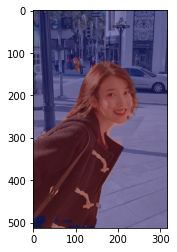

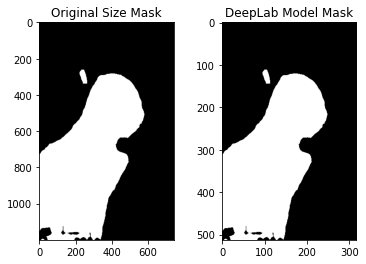

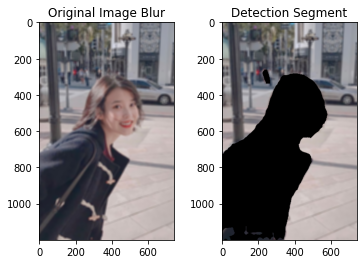

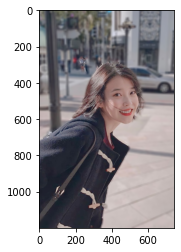

In [22]:
save(make_portrait('human2.jpeg',15), 'human2_portrait')

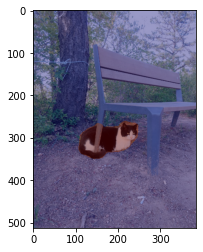

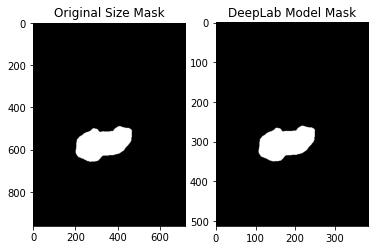

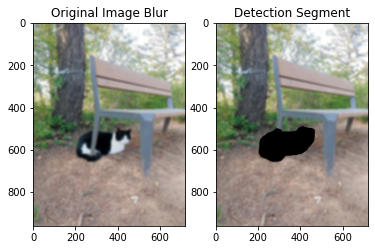

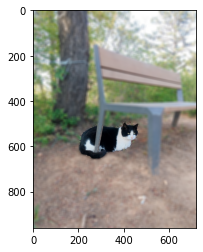

In [23]:
save(make_portrait('cat3.jpg',8), 'cat3_portrait')

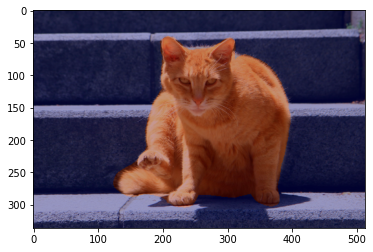

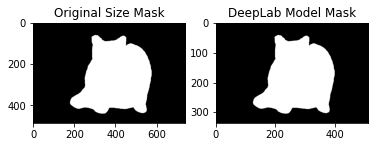

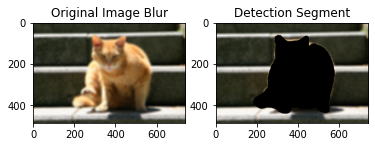

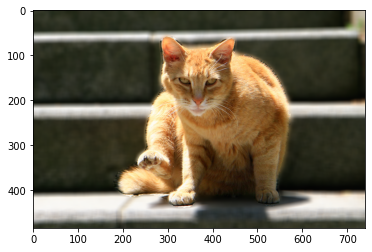

In [24]:
cat_portrait = make_portrait('cat4.jpg', 8)
save(cat_portrait, 'cat4_portrait')

## 6-2. 크로마키 합성 함수
- def `make_chromakey(img_name, mode, chromakey)`
    - 이미지 파일명과 분석하고 싶은 객체명, 합성하고자 하는 배경 이미지 파일명을 인자로 받아 배경 이미지가 합성된 cv2 이미지 객체를 반환한다.
    - 크로마키 배경 이미지가 원본 이미지보다 큰 경우 그에 맞춰서 사이즈를 줄인다.

In [25]:
def make_chromakey(img_name, mode, chromakey):
    '''
        mode = 15면 사람
        mode = 8이면 고양이
    '''
    img_path = os.getenv('HOME')+'/aiffel/enode8/human_segmentation/images/'+img_name
    chrom_path = os.getenv('HOME')+'/aiffel/enode8/human_segmentation/images/'+chromakey
    # 이미지 불러오기
    img_orig = cv2.imread(img_path)

    # DeepModel에서 이미지 사이즈 줄이고 세그멘테이션된 특징 맵 반환
    img_resized, seg_map = MODEL.run(img_orig)
    img_show = img_resized.copy()

    # 전체 세그멘테이션 맵 중 사람만 추출 15-사람
    seg_map = np.where(seg_map == mode, mode, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)

    # 인물영역 마스크 시각화
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 마스크를 원본 이미지 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) ## 확실한 경계 정하기


    # 세그멘테이션 마스크 크기 시각화
    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 크로마키 이미지
    img_origin_chrom = cv2.imread(chrom_path)
    
    # 크로마키 이미지 크기 조절
    img_chrom = cv2.resize(img_origin_chrom, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    # 흐려진 이미지에서 배경 추출
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_chrom, img_bg_mask)
    
    ax = plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    ax.set_title('Detection Segment')

    # 크로마키과 원본 이미지 인물 합성
    img_concat = np.where(img_mask_color==255, img_orig, img_chrom)

    ax = plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    ax.set_title('Output')
    plt.show()

    return img_concat

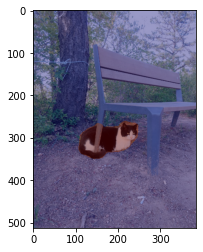

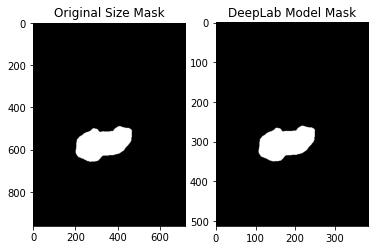

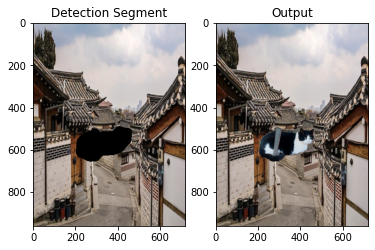

In [26]:
cat_with_house = make_chromakey('cat3.jpg',8, 'bg1.jpg')

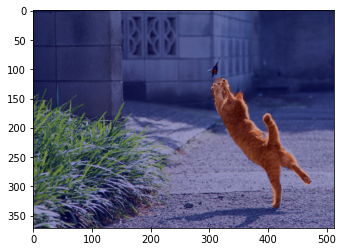

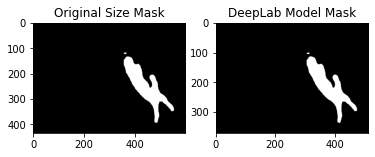

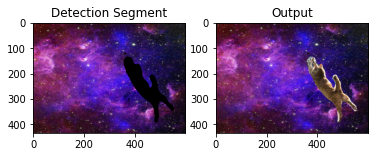

In [27]:
cat_in_the_cosmic = make_chromakey('cat2.jpg', 8, 'bg2.jpg')

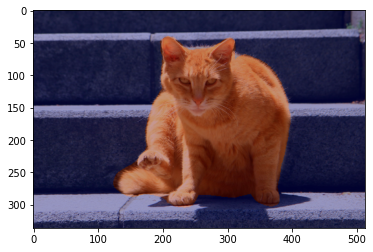

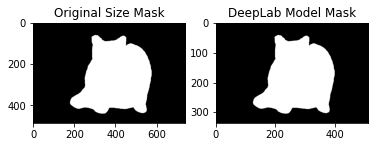

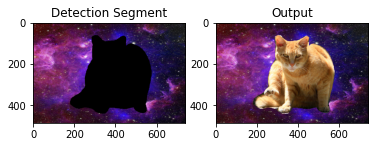

In [28]:
save(make_chromakey('cat4.jpg',8,'bg2.jpg'),'cat4_in_the_cosmic')

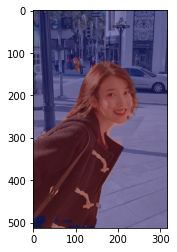

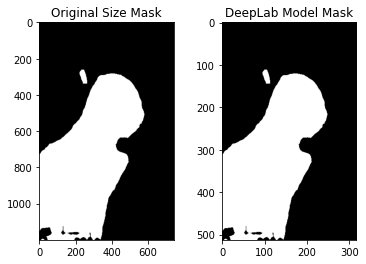

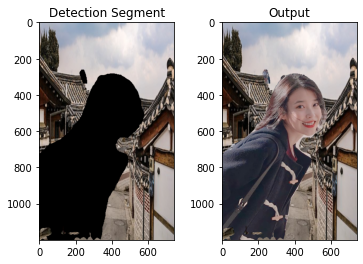

In [29]:
save(make_chromakey('human2.jpeg',15,'bg1.jpg'),'human2_chromakey')

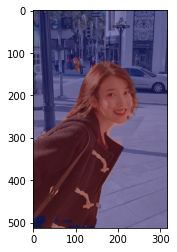

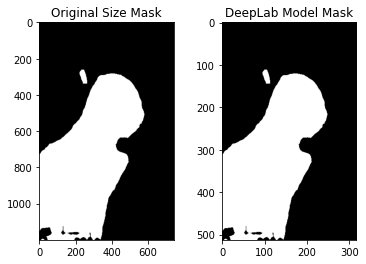

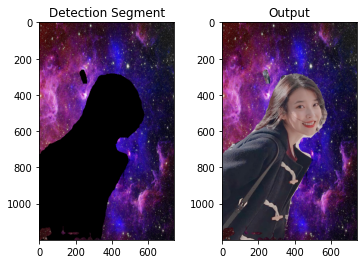

In [30]:
save(make_chromakey('human2.jpeg',15,'bg2.jpg'),'human2_chromakey2')

# step7) 문제점 분석

## 7-1. 셸로우 포커스 문제점

- 인물의 자세가 비교적 복잡할 경우 검출된 영역이 정교하지 않아서 배경 부분이 미처 블러처리 되지 않았다.
- 배경색과 인물의 의상 색이 비슷할 경우 정확하게 검출하지 못해서 일부분이 블러처리 되는 것을 볼 수 있었다.
- 소지품 같은 경우는 같이 검출되는 것이 더욱 자연스러울 것 같다.
- 일괄적으로 블러를 적용하다보니 객체 경계가 명확하지 않은 부분이 심하게 드러난다.

![인물1](segmentation_problem/problem1.jpeg)

- 메인 객체만 검출하는 것이 아니라 사람이면 다 검출하기 때문에 배경에 있는 사람도 블러 처리가 되지 않았다.
- 배경과 색이 비슷한 코트 단추 부분이 제대로 검출되지 않았고 코트 색과 비슷한 전봇대도 포함되었다.

![인물2](segmentation_problem/problem2.jpeg)

- 배경색과 객체 색이 뚜렷하게 구분되고 객체의 형태가 비교적 단순한 경우 일부분 객체 경계 밖 부분을 검출했어도 크게 어색하지 않은 결과를 보였다.

![고양이아웃포커스](human_segmentation/images/cat4_portrait.png)

- 그러나 객체를 관통하는 다른 물체가 있는 경우에는 이를 분리해내지 못하여 같이 객체로 검출해버려서 어색한 결과가 나왔다.

![벤치고양이](segmentation_problem/problem3.jpeg)

## 7-2. 크로마키 문제점

- 크로마키 합성용 배경 이미지가 원본 대상이 있는 이미지보다 큰 경우 `cv2.resize()`를 통해 원본 이미지 사이즈로 맞추어 주었는데 패턴이 있는 이미지에서는 큰 위화감이 없었다.

- 원본 이미지에서 세그멘테이션 정확도가 떨어지는 경우 원본 이미지의 배경과 크로마키 이미지 사이에 색 차이가 심한 경우 차이가 더욱 명확하게 드러났다.

![우주고양이](segmentation_problem/problem4.jpeg)

- 아웃포커싱에서는 자연스러웠던 이미지도 원본 배경과 색 차이가 심하게 나는 크로마키 이미지에 합성할 경우 육안 상으로 깔끔하게 검출이 되지 않은 부분을 볼 수 있었다.

![우주고양이2](segmentation_problem/problem5.jpeg)

- 하지만 건축물 등 구조물이 있는 경우 이미지가 일그러진 티가 심하게 났다.

![한옥고양이](segmentation_problem/problem6.jpeg)

- 크로마키 배경 이미지가 더 큰 경우 원본 이미지 영역에 맞게 crop해 사용하거나 객체가 검출된 영역을 배경 이미지에 붙이는 식으로 수정해봐야겠다.

- 객체가 전체 사진에서 차지하는 비율이 큰 경우에도 어색함이 느껴진다.

![인물크로마키](segmentation_problem/human2_chromakey.jpg)

![인물크로마키2](segmentation_problem/human2_chromakey2.jpg)

# step8) 해결방법 제안

- 앞에서 발생한 문제를 정리해보자면
    1. 배경색상과 객체색상이 비슷한 경우 깔끔하게 객체를 정확하게 분리해내지 못한다.
    2. 객체의 형태가 복잡하면 검출된 객체에서 배경이 많이 포함된다.
- 이렇게 크게 두 가지의 공통적인 문제를 볼 수 있다.

- 이 문제를 해결하기 위해서는 객체와 배경 간의 경계를 더욱 확실하게 전처리하는 과정이 필요해 보인다.

## 8-0. (참고) Pixel2의 Portrait Mode
- 실제 구글의 스마트폰 Pixel2와 Pixel2 XL는 DeepLab V3+를 사용해 Portrait Mode를 구현했다.

[Portrait mode on the Pixel 2 and Pixel 2 XL smartphones](https://ai.googleblog.com/2017/10/portrait-mode-on-pixel-2-and-pixel-2-xl.html)
- 배경과 객체를 더욱 잘 분리하기 위해 이들이 사용한 방법을 살펴보자.
- Pixel2는 전면, 후면 모두 Portrait Mode를 제공하는데,
    - 전면 카메라의 경우는 오직 세그멘테이션 기술만을 이용해 구현되었다.
    - 후면 카메라는 렌즈가 한 개지만 스테레오 이미지와 세그멘테이션 기술을 이용해 구현되었다.

1. `HDR+`을 사용해 이미지의 경계를 샤프닝한다.
    - 연속 촬영으로 확보한 여러개의 이미지를 조합해서 너무 밝아진 부분들을 버리고
    - 그림자에 노이즈를 줄이기 위해서 프레임들을 정렬하고 조합한다.
    - 이미지의 디테일이 날카로워진다.
    
    
2. `DeepLab`으로 배경과 객체를 분리한다
    - CNN을 통해 세그멘테이션 마스크를 만든다.
    - 머리카락이나 들고 있는 소지품 등도 객체의 일부로 분류되어 블러 처리하지 않는다.
    
    
3. `stereo`알고리즘으로 듀얼 픽셀들에서 depth map 구하기
    - depth map이 없으면 배경의 객체들이 다양한 깊이를 가지고 있음에도 일괄적으로 블러 처리하게 된다.
    - 물리적 렌즈가 두 개가 아니더라도 `PDAF`(`DPAF`) 기술을 활용해 듀얼 픽셀을 얻는다.
        ➡ 왼쪽과 오른쪽 렌즈의 픽셀 차이를 1mm 안팍으로 만든다.
    - `stereo` 알고리즘을 사용하기 위해 Green 픽셀값만 사용한다.
    - 구한 depth map을 참고해 픽셀의 블러 정도를 결정한다.
    
    
4. 전처리한 결과를 이미지에 병합해 최종 이미지를 렌더링 한다.
    - 세그멘테이션 마스크와 depth map을 조합해 배경의 각 픽셀을 얼마나 블러 처리할 지 정한다.
    - 원본 이미지에 블러 처리한다.

## 8-1. 개선 방안 제안
1. 이미지 밝기를 다양하게 조절하고 이를 정렬, 조합해서 객체 간 경계가 뚜렷해진 이미지를 만든다.
2. DeepLab 모델을 통해 세그멘테이션 마스크를 만들어 낸다.
3. 이미지를 왼쪽, 오른쪽으로 일정 픽셀 이동시키고 두 이미지를 조합해 depth map을 얻어낸다.
4. depth map에 맞게 픽셀마다 블러 정도를 다르게 적용한다.
5. 배경합성의 경우는 세그멘테이션 마스크 영역에서 depth 차가 존재하는 경우 배경이미지와 원본이미지를 블렌딩해서 경계를 지워보자.

- 실제 여러 프레임을 찍어서 조합한 것과 한 장의 이미지로 밝기를 조절해 얻는 결과에는 분명히 정확도 차이가 있겠지만 원본 이미지에서 객체를 검출하는 것 보다는 더 정확한 결과를 보일 것이라고 생각한다.
- 현재까지 발견된 대부분의 문제 역시 객체의 정확한 경계를 잡아내지 못해서 발생하는 것이므로 이 방법으로 꽤 많은 문제가 해결될 것이다.
- 그리고 depth map을 통해서 블러 정도를 다르게 적용하면 객체 경계 바깥 부분이 포함된 경우에도 자연스럽게 연결될 것이다.

# 회고
- 완성도 높은 하나의 소프트웨어를 만드려면 그 뒤에 많은 고민들이 숨어있었겠구나.
- 구글의 `HDR+` 구현 방법을 자세히 알아보자 [HDR+: Low Light and High Dynamic Range photography in the Google Camera App](https://ai.googleblog.com/2014/10/hdr-low-light-and-high-dynamic-range.html)
- `PDAF` 개념을 알아봐야겠다.